In [1]:
import sys
sys.path.insert(0, '..')
#for local import of parent dict

import scanpy as sc
import pandas as pd
import numpy as np
import pathlib
import scipy
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

from ggml.plot import plot_heatmap, hier_clustering, plot_emb, plot_ellipses
from ggml.generator import get_pointcloud
from tqdm import tqdm

import ot

from ggml.benchmark import knn_from_dists, plot_table, plot_1split
import pickle

5.660704928275037e-15


/home/kuehn/anaconda3/envs/ggml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Define path and computed datasets
results_path = "/home/kuehn/ot_metric_learning/damin-ggml/data/results/clustering/paper"
computed_datasets = ["synth_2D_synth_200D_allmethods.pickle","kidney_full.pickle","breastcancer_full.pickle","myocard_infarct.pickle"] #,"synth_2D_synth_200D_breastcancer_full.pickle"]

#Define order of methods and which metrics you want to display/hide. (e.g. clustering or classification)
method_col = ['Euclidean', 'Manhatten', 'Cosine', 'LMNN', 'LFDA', 'NCA', 'ITML','GGML','GGML_L2'] #metrics.keys()
hide_metrics = ["KNN"]

In [3]:
results = {}
for d in computed_datasets:
    with open(f"{results_path}/{d}", 'rb') as handle:
            res = pickle.load(handle)
            print(res)
            results = results | res


{'synth_2D': {'GGML': {'global': {'KNN': '0.93±0.00', 'MI': np.float64(0.5021853144982367), 'ARI': 0.4298134835997084, 'VI': np.float64(1.1876646819153862)}, 'ground': {'KNN': '0.96±0.05', 'MI': np.float64(1.0986122886681096), 'ARI': 1.0, 'VI': np.float64(4.440892098500626e-16)}}, 'Euclidean': {'global': {'KNN': '0.32±0.01', 'MI': np.float64(0.00010647796277080124), 'ARI': -0.0005644254830748265, 'VI': np.float64(2.1939674727597325)}, 'ground': {'KNN': '0.29±0.10', 'MI': np.float64(0.0), 'ARI': -0.07288790723357261, 'VI': np.float64(2.1875122640133333)}}, 'Manhatten': {'global': {'KNN': '0.34±0.01', 'MI': np.float64(0.00010411256965139892), 'ARI': -0.0005489336363136319, 'VI': np.float64(2.1876480649227004)}, 'ground': {'KNN': '0.29±0.10', 'MI': np.float64(0.0), 'ARI': -0.07288790723357261, 'VI': np.float64(2.1875122640133333)}}, 'Cosine': {'global': {'KNN': '0.47±0.01', 'MI': np.float64(0.06077970714904078), 'ARI': 0.027264419445940942, 'VI': np.float64(2.4524658956164567)}, 'ground':

In [4]:
#results[data][metric_name]["global" if l==0 else "ground"]["MI"]



results_ground_cols = {(d,s):[] for d in results.keys() for s in next(iter(results[d].values()))["ground"].keys() if s not in hide_metrics }
results_global_cols = {(d,s):[] for d in results.keys() for s in next(iter(results[d].values()))["global"].keys() if s not in hide_metrics}

for d in results:
    for m in method_col: #results[d]:
        if m in results[d]:
            for s in results[d][m]["ground"]:
                if s not in hide_metrics:
                    results_ground_cols[(d,s)].append(f"{results[d][m]["ground"][s]:.2f}")
            for s in results[d][m]["global"]:
                if s not in hide_metrics:
                    results_global_cols[(d,s)].append(f"{results[d][m]["global"][s]:.2f}")  
        else:
            #If values were not compute input "--"
            for s in next(iter(results[d].values()))["ground"].keys():
                if s not in hide_metrics:
                    results_ground_cols[(d,s)].append("--")
                    results_global_cols[(d,s)].append("--")   

results_ground_cols["method"] = method_col 
results_global_cols["method"] = method_col 


plot_table(pd.DataFrame(results_ground_cols))
plot_table(pd.DataFrame(results_global_cols))

,"(synth_2D, MI)","(synth_2D, ARI)","(synth_2D, VI)","(synth_200D, MI)","(synth_200D, ARI)","(synth_200D, VI)","(kidney_full, MI)","(kidney_full, ARI)","(kidney_full, VI)","(breastcancer_full, MI)","(breastcancer_full, ARI)","(breastcancer_full, VI)","(myocard_infarct_full, MI)","(myocard_infarct_full, ARI)","(myocard_infarct_full, VI)"
method,,,,,,,,,,,,,,,
Euclidean,0.00,-0.07,2.19,0.00,-0.07,2.15,0.07,0.02,1.11,0.01,-0.02,0.68,0.11,0.02,1.21
Manhatten,0.00,-0.07,2.19,0.00,-0.07,2.19,0.07,0.02,1.11,0.03,0.13,0.93,0.22,0.17,1.00
Cosine,0.11,0.03,1.83,0.07,-0.00,1.24,0.07,0.02,1.11,0.01,-0.02,0.68,0.07,0.00,1.19
LMNN,0.01,-0.06,2.14,0.02,-0.05,2.15,--,--,--,--,--,--,--,--,--
LFDA,0.06,-0.02,2.05,0.07,-0.00,1.35,0.05,-0.01,1.39,0.06,0.13,0.68,0.64,0.53,0.75
NCA,0.01,-0.06,2.15,0.05,-0.02,2.10,--,--,--,--,--,--,--,--,--
ITML,0.20,0.04,1.60,0.08,-0.00,1.63,0.06,0.01,1.27,0.01,-0.02,0.68,0.09,0.03,1.15
GGML,1.10,1.00,0.00,1.10,1.00,0.00,--,--,--,--,--,--,0.82,0.83,0.41
GGML_L2,--,--,--,--,--,--,0.77,0.81,0.34,0.21,0.49,0.79,0.91,0.92,0.20


\begin{tabular}{llllllllllllllll}
\toprule
 & ('synth_2D', 'MI') & ('synth_2D', 'ARI') & ('synth_2D', 'VI') & ('synth_200D', 'MI') & ('synth_200D', 'ARI') & ('synth_200D', 'VI') & ('kidney_full', 'MI') & ('kidney_full', 'ARI') & ('kidney_full', 'VI') & ('breastcancer_full', 'MI') & ('breastcancer_full', 'ARI') & ('breastcancer_full', 'VI') & ('myocard_infarct_full', 'MI') & ('myocard_infarct_full', 'ARI') & ('myocard_infarct_full', 'VI') \\
method &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Euclidean & 0.00 & -0.07 & 2.19 & 0.00 & -0.07 & 2.15 & 0.07 & 0.02 & 1.11 & 0.01 & -0.02 & 0.68 & 0.11 & 0.02 & 1.21 \\
Manhatten & 0.00 & -0.07 & 2.19 & 0.00 & -0.07 & 2.19 & 0.07 & 0.02 & 1.11 & 0.03 & 0.13 & 0.93 & 0.22 & 0.17 & 1.00 \\
Cosine & 0.11 & 0.03 & 1.83 & 0.07 & -0.00 & 1.24 & 0.07 & 0.02 & 1.11 & 0.01 & -0.02 & 0.68 & 0.07 & 0.00 & 1.19 \\
LMNN & 0.01 & -0.06 & 2.14 & 0.02 & -0.05 & 2.15 & -- & -- & -- & -- & -- & -- & -- & -- & -- \\
LFDA & 0.06 & -0.02 & 2.05 & 0.07 & 

,"(synth_2D, MI)","(synth_2D, ARI)","(synth_2D, VI)","(synth_200D, MI)","(synth_200D, ARI)","(synth_200D, VI)","(kidney_full, MI)","(kidney_full, ARI)","(kidney_full, VI)","(breastcancer_full, MI)","(breastcancer_full, ARI)","(breastcancer_full, VI)","(myocard_infarct_full, MI)","(myocard_infarct_full, ARI)","(myocard_infarct_full, VI)"
method,,,,,,,,,,,,,,,
Euclidean,0.00,-0.00,2.19,0.00,-0.00,2.19,0.18,0.00,3.17,0.11,-0.00,2.87,0.29,0.11,2.83
Manhatten,0.00,-0.00,2.19,0.00,-0.00,2.19,0.15,0.01,3.12,0.06,0.02,2.33,0.27,0.11,2.25
Cosine,0.06,0.03,2.45,0.31,0.00,3.01,0.18,0.00,3.09,0.11,0.03,2.91,0.33,0.09,3.40
LMNN,0.01,0.01,2.13,0.00,0.00,1.78,--,--,--,--,--,--,--,--,--
LFDA,0.07,0.03,1.91,0.00,0.00,2.14,0.04,-0.01,2.74,0.04,0.06,2.47,0.51,0.64,0.71
NCA,0.01,0.00,2.17,0.01,0.01,1.77,--,--,--,--,--,--,--,--,--
ITML,0.13,0.09,1.84,0.02,0.00,2.10,0.04,0.00,2.47,0.02,0.04,2.27,0.07,0.01,2.77
GGML,0.50,0.43,1.19,0.68,0.61,0.85,--,--,--,--,--,--,0.07,0.05,2.83
GGML_L2,--,--,--,--,--,--,0.14,0.10,1.83,0.06,0.06,1.61,0.63,0.71,0.81


\begin{tabular}{llllllllllllllll}
\toprule
 & ('synth_2D', 'MI') & ('synth_2D', 'ARI') & ('synth_2D', 'VI') & ('synth_200D', 'MI') & ('synth_200D', 'ARI') & ('synth_200D', 'VI') & ('kidney_full', 'MI') & ('kidney_full', 'ARI') & ('kidney_full', 'VI') & ('breastcancer_full', 'MI') & ('breastcancer_full', 'ARI') & ('breastcancer_full', 'VI') & ('myocard_infarct_full', 'MI') & ('myocard_infarct_full', 'ARI') & ('myocard_infarct_full', 'VI') \\
method &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Euclidean & 0.00 & -0.00 & 2.19 & 0.00 & -0.00 & 2.19 & 0.18 & 0.00 & 3.17 & 0.11 & -0.00 & 2.87 & 0.29 & 0.11 & 2.83 \\
Manhatten & 0.00 & -0.00 & 2.19 & 0.00 & -0.00 & 2.19 & 0.15 & 0.01 & 3.12 & 0.06 & 0.02 & 2.33 & 0.27 & 0.11 & 2.25 \\
Cosine & 0.06 & 0.03 & 2.45 & 0.31 & 0.00 & 3.01 & 0.18 & 0.00 & 3.09 & 0.11 & 0.03 & 2.91 & 0.33 & 0.09 & 3.40 \\
LMNN & 0.01 & 0.01 & 2.13 & 0.00 & 0.00 & 1.78 & -- & -- & -- & -- & -- & -- & -- & -- & -- \\
LFDA & 0.07 & 0.03 & 1.91 & 0.00 & 0.00 

In [5]:
#Prepare plotting on cell level
#TODO move to different notebook

#print(precomputed_ground_distances[dataset_name]["GGML"])
print( datapoints_over_split.keys())
dataset_name = "myocard_infarct_full"
metric_name = "GGML_L2" #GGML" Euclidean" #

thresh = 0.9
accuracy = datapoints_over_split[f"{dataset_name}_{metric_name}"]
print(accuracy)
selected_cells_ind = np.arange((len(accuracy))) #np.where((accuracy>=thresh))[0] #
print(selected_cells_ind)
data_points = datasets[dataset_name]["points"][selected_cells_ind]
print(datasets[dataset_name]["distribution_modes"])
cell_types = np.concatenate(datasets[dataset_name]["distribution_modes"])[selected_cells_ind]
#cell_types = [mapping[l] for l in cell_types]

n_most_cells = 5
cells_n_min = np.sort(np.unique(cell_types, return_counts=True)[1])[-(n_most_cells-1)]

unique, counts = np.unique(cell_types, return_counts=True)
total_other = 0
celltype_accuracy = {}
for u,c in zip(unique, counts):
    celltype_accuracy[u]=np.average(accuracy[selected_cells_ind][cell_types==u])
    if c < cells_n_min:
        cell_types[cell_types==u] = "other"
        total_other += c    
print(celltype_accuracy)
print(total_other)



NameError: name 'datapoints_over_split' is not defined

In [6]:
#Plot cell level emb + barycenter

labels = np.asarray(datasets[dataset_name]["point_labels"])[selected_cells_ind]

theta = metric_params[dataset_name][metric_name]
theta2 = metric_params[dataset_name]["Euclidean"]

cell_dist1 = pairwise_mahalanobis_distance_npy(data_points,w = theta)
cell_dist2 = pairwise_mahalanobis_distance_npy(data_points,w = theta2)


cell_dist = (cell_dist1/np.average(cell_dist1) + cell_dist2/np.average(cell_dist2))/2


emb1 = plot_emb(cell_dist1,method='umap',colors=labels,symbols=cell_types,legend="auto",title=f"{metric_name} UMAP",verbose=True,annotation=None,s=15)
emb2 = plot_emb(cell_dist1,method='phate',colors=labels,symbols=cell_types,legend="Side",title=f"{metric_name} Phate",verbose=True,annotation=None,s=15)



NameError: name 'datasets' is not defined

other


array([[-0.02609817, -0.00210386],
       [-0.01404321,  0.01004687],
       [-0.02177599,  0.01007563],
       ...,
       [-0.02064014,  0.01053473],
       [-0.02622819,  0.00019392],
       [-0.02571563,  0.00093112]])

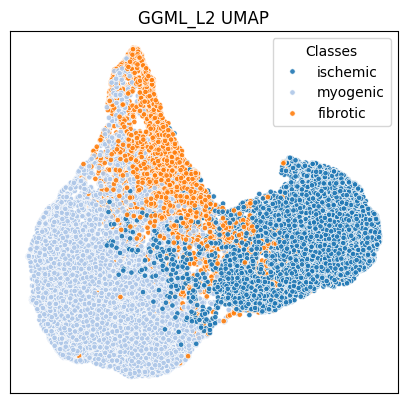

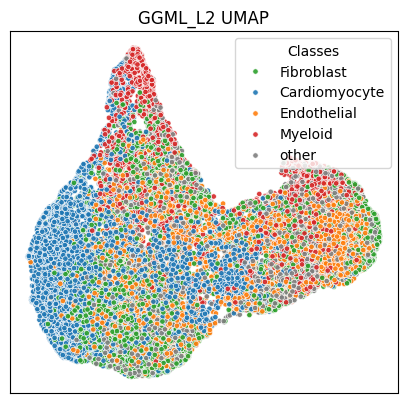

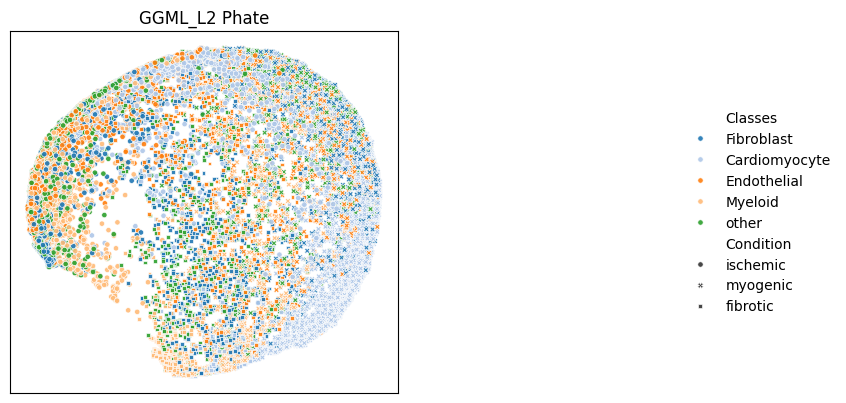

In [50]:
#manually enforce colorpalette
cmap = sns.color_palette("tab10")
palette = {}
for i,label in enumerate(np.unique(cell_types)):
    if label == "other":
        palette[label]=cmap[7]
        print("other")
    else:
        palette[label]=cmap[i]

plot_emb(cell_dist1,precomputed_emb=emb1,method='umap',colors=labels,legend="auto",title=f"{metric_name} UMAP",verbose=True,annotation=None,s=15)
plot_emb(cell_dist1,precomputed_emb=emb1,method='umap',colors=cell_types,cmap=palette,legend="auto",title=f"{metric_name} UMAP",verbose=True,annotation=None,s=15)
plot_emb(cell_dist1,precomputed_emb=emb2,method='phate',colors=cell_types,legend="Side",symbols=labels,title=f"{metric_name} Phate",verbose=True,annotation=None,s=15)

[[13.55965     1.6875395 ]
 [ 7.2840977   3.1018987 ]
 [10.074497    1.1562829 ]
 ...
 [ 9.901529   -0.08763672]
 [12.180356    2.7156124 ]
 [11.808677    3.3408017 ]]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 1

array([[13.55965   ,  1.6875395 ],
       [ 7.2840977 ,  3.1018987 ],
       [10.074497  ,  1.1562829 ],
       ...,
       [ 9.901529  , -0.08763672],
       [12.180356  ,  2.7156124 ],
       [11.808677  ,  3.3408017 ]], dtype=float32)

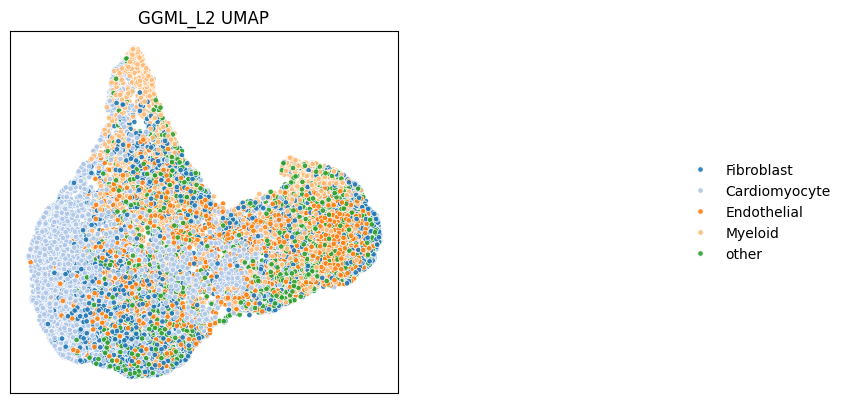

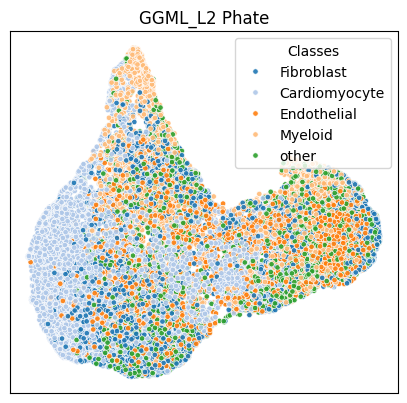

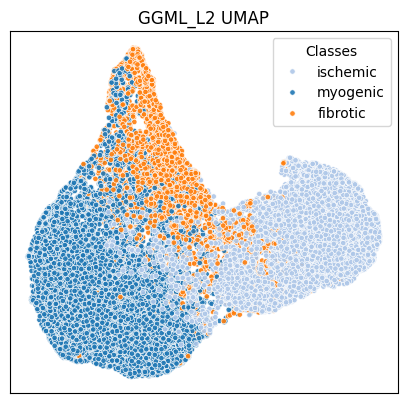

In [48]:
#plot emb of cells with high accuracy
%reload_ext autoreload
%autoreload 2
print(emb1)

cells = np.unique(cell_types) # ["tcells","fibroblasts","myeloid"]

filter_ind = [i for i,l in enumerate(cell_types) if l in cells]
print(filter_ind)
sub_cell_dist = cell_dist[filter_ind,:][:,filter_ind]
sub_emb = emb1[filter_ind,:]
print(sub_emb)
sub_labels = labels[filter_ind]
sub_cell_types = np.asarray(cell_types)[filter_ind]


plot_emb(sub_cell_dist,precomputed_emb=sub_emb,method='umap',colors=sub_cell_types,legend="Side",title=f"{metric_name} UMAP",verbose=True,annotation=None,s=15)
plot_emb(sub_cell_dist,precomputed_emb=sub_emb,method='phate',colors=sub_cell_types,legend="auto",title=f"{metric_name} Phate",verbose=True,annotation=None,s=15)
#plot_emb(sub_cell_dist,precomputed_emb=emb2,method='phate',colors=sub_cell_types,legend="Side",title=f"{metric_name} Phate",verbose=True,annotation=None,s=15)

cmap = sns.color_palette("tab20")
palette = {}
for i,label in enumerate(np.unique(cell_types)):
    if label == "other":
        palette[label]=cmap[8]
    else:
        palette[label]=cmap[i]
        
cmap = sns.color_palette("tab20")
palette = {
    "myogenic": cmap[0],
    "ischemic": cmap[1],
    "fibrotic": cmap[2],
   
}
#palette="tab20"

plot_emb(sub_cell_dist,precomputed_emb=sub_emb,method='umap',colors=sub_labels,legend="auto",cmap=palette,title=f"{metric_name} UMAP",verbose=True,annotation=None,s=15)
#plot_emb(sub_cell_dist,precomputed_emb=emb2,method='phate',colors=sub_labels,legend="auto",cmap=palette,title=f"{metric_name} Phate",verbose=True,annotation=None,s=15)


In [49]:
import sklearn 
import scipy as sp
from ggml.benchmark import knn_from_dists

def compute_dist_matrix(X,d):
    D = np.zeros((len(X),len(X)))
    for i,x in enumerate(X):
        for j,y in enumerate(X):
            if i<=j:
                D[i,j] = d(x,y)
            else:
                D[i,j] = D[j,i]
    return D

results = {"method":[],
           #"KNN T=0.75":[],
           "KNN T=0.25":[],
           "ARI":[],
           #"VarInf":[],
           
           #"Time":[]}
}
fig, axs = plt.subplots(1,len(metrics.keys()),figsize=(len(methods.keys())*5,5),squeeze=False)

for m, (method, trained_metric) in enumerate(methods.items()):
    if method=="ggml" or m == "baseline" or m == "groundtruth":
        #d = trained_metric
        if m == "baseline" or m == "groundtruth":
            continue
        theta = np.asarray([[-20.6616, 0],[0, 0.0407]])
        d= lambda x,y: np.linalg.norm(np.squeeze(np.dot(theta,x))-np.squeeze((np.dot(theta,y)))) 
    else:
        d = trained_metric.get_metric()

    D = compute_dist_matrix(flat_dists,d)

    print(D.shape)

    pred, true, score, _ = knn_from_dists(D,flat_labels,method=method,weights=None,test_size=0.5,n_splits=20,n_neighbors=30) #'distance'
    #for i,(p,t) in enumerate(zip(pred,true)):
    #plot_1split(np.concatenate(pred),np.concatenate(true),title=f"{method} Distance KNN {len(pred)}-Splits",ax=axs[0,m])

    #pred2, true2, score2, ari = KNN_from_dists(graphs,labels,method=method,precomputed_dists=precomputed_dists[method],weights='distance',test_size=0.9)
    #for i,(p,t) in enumerate(zip(pred,true)):
    #plot_1split(np.concatenate(pred2),np.concatenate(true2),title=f"{method} Distance KNN {len(pred2)}-Splits",ax=axs[1,m])

    #zero_dia_dists = precomputed_dists[method]
    #np.fill_diagonal(zero_dia_dists,0)
    #sil = silhouette_score(zero_dia_dists,labels,metric="precomputed")

    #ari = adjusted_rand_score(np.concatenate(true),np.concatenate(pred))
    
    pred_cluster = sklearn.cluster.AgglomerativeClustering(n_clusters=len(np.unique(flat_labels)),metric='precomputed',linkage='average').fit_predict(D)
    ari = sklearn.metrics.adjusted_rand_score(flat_labels,pred_cluster)
    print(ari)

    link = sp.cluster.hierarchy.linkage(sp.spatial.distance.squareform(D), method='average', optimal_ordering=True)
    pred_cluster = sp.cluster.hierarchy.fcluster(link,t=len(np.unique(flat_labels)),criterion="maxclust")
    ari = sklearn.metrics.adjusted_rand_score(flat_labels,pred_cluster)
    print(pred_cluster)


    #_ , grouped_labels = np_unique_indices(labels) #[np.where([labels==l]) for l in np.unique(labels)]
    #_ , grouped_clust = np_unique_indices(pred_cluster) #[np.where([pred_cluster==l]) for l in np.unique(pred_cluster)]
    #print(grouped_labels)
    #print(grouped_clust)
    #truth = NodeClustering(grouped_labels, graph=None, method_name="Pathological labels")
    #pred = NodeClustering(grouped_clust, graph=None, method_name="Predicted Cluster")
    #eval = cdlib.evaluation.variation_of_information(truth,pred)

    #plt.show()
    results["method"].append(method)
    #results["Classification Score"].append(np.average(score))
    #results["KNN T=0.75"].append(f"{np.average(score):.2f}±{np.std(score):.2f}")

    results["KNN T=0.25"].append(f"{np.average(score):.2f}±{np.std(score):.2f}")

    results["ARI"].append(f"{np.average(ari):.2f}")
    #results["VarInf"].append(eval[0])
    #results["SC"].append(("%.3f" % sil).replace("-0","-").lstrip("0")) 
    #results["Time"].append(f"{times[method]/(len(ccb_emb[0])*(len(ccb_emb[0])-1)/2) * 1000: .2f}")

fig.tight_layout()
plot_table(pd.DataFrame(results))

NameError: name 'methods' is not defined